PA9: Neural Networks with Tensorflow

In this assignment, you will:

1. Implement neural networks as a powerful approach to supervised machine learning,
2. Practice using state-of-the-art software tools and programming paradigms for machine learning,
3. Investigate the impact of parameters to learning on neural network performance as evaluated on an empirical data set.

For this assignment, we will learn use a well known dataset:

[Higgs](https://archive.ics.uci.edu/ml/datasets/HIGGS). Some information regarding this dataset: The data has been produced using Monte Carlo simulations. The first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes.

For local testing you will use the sample dataset provided to you with this notebook.
When submitting on EdX, your code will be evaluated on a much larger sample of this dataset.

The file format for each of the above data set is as follows:

• The first row contains a comma-separated list of the names of the label and attributes

• Each successive row represents a single instance

• The first entry of each instance is the label to be learned, and all other entries (following the commas) are attribute values.

• All attributes are numerical i.e. real numbers.

Exercise 1: 

Your goal is to complete the below function named train_nn that behaves as follows:

1) It should take as input six parameters:
    
    a. The path to a file containing a data set (e.g., higgs_sample.csv)
    
    b. The number of neurons to use in the hidden layer
    
    c. The learning rate to use during backpropagation
    
    d. The number of iterations to use during training
    
    e. The percentage of instances to use for a training set
    
    f. A random seed as an integer
    
    
For example, if the call to train_nn looks like train_nn(higgs_sample.csv 20 0.001 1000 0.75 12345) which will create a neural network with 20 neurons in the hidden layer, train the network using a learning rate = 0.001 and 1000 iterations through higgs_sample.csv with a random seed of 12345, where 75% of the data will be used for training (and the remaining 25% will be used for testing)

2) You should create a neural network in Tensorflow that will be learned from the training data. The key parameters to the architecture of the neural network are based on your inputted parameters and the size of your data set:
    
    a. The number of attributes in the input layer is the length of each instance’s
    attribute list (which is the same for all instances)
    
    b. The number of neurons in a hidden layer will be inputted to the program as a
    parameter. Each hidden neuron should use tf.sigmoid as its activation function.
    
    c. The number of output neurons will be 1 since it is a binary classification task, and that should use tf.sigmoid as its activation function
    
3) You should use different cost/loss functions that the network tries to minimize depending on the number of labels:
    
    a. For binary classification we will use the cross entropy loss function:
    
    TODO: get latex version from here: https://stackoverflow.com/questions/46291253/tensorflow-sigmoid-and-cross-entropy-vs-sigmoid-cross-entropy-with-logits
    
    b. You will use full batch gradient descent (No mini batching is required, but you may optionlly do it) TODO: change this if grading scheme does not conform to this.

## TODO: edit this to use cross entropy loss

$$SSE(X) = \sum_{j=1}^{n}({y_j - \hat{y}_j})^2$$


    The function tf.reduce_sum will allow you to sum across all instances.
    

4) For the implementation of Backpropagation, you should use tf.train.AdamOptimizer

For more on optimizers, you may follow this link: TODO

5) You should train your network using your inputted learning rate and for the inputted number of iterations. The iterations are simply a loop that calls Backpropagation a fixed number of times.

TODOs:

- Biases?
- Mean normalize?
- How to evaluate?


In [1]:
import yaml
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import numpy as np

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
with open("nn_config.yaml", 'r') as ymlfile:
    try:
        cfg = yaml.load(ymlfile)
    except yaml.YAMLError as err:
        print(err)

In [3]:
file_name = cfg['training_data_path']
test_file_name = cfg['test_data_path']

In [4]:
data = np.loadtxt(file_name, delimiter = ',')

In [5]:
test = np.loadtxt(test_file_name, delimiter = ',')

In [6]:
def normalize(train):
    mean, std = train.mean(), train.std()
    train = (train - mean) / std
    return train

In [7]:
def parse_data(numpy_matrix):
    labels = numpy_matrix[:,0]
    features = normalize(numpy_matrix[:,1:])
    return labels, features
labels, features = parse_data(data)

In [8]:
test_labels, test_features = parse_data(test)

## TF DATA reader 


filename_queue = tf.train.string_input_producer([file_name])

dataset = tf.data.TextLineDataset(filenames)
#line_reader = tf.TextLineReader()
key, csv_row = line_reader.read(filename_queue)

record_defaults = [[0.0]]*29
all_columns = tf.decode_csv(csv_row, record_defaults=record_defaults)

# Turn the features back into a tensor.
features = tf.stack(all_columns[1:])
labels = tf.stack(all_columns[0])

## Continue here 

In [9]:
# Parameters
learning_rate = cfg['learning_rate']
training_epochs = 200#cfg['max_epochs']
train_valid_split = cfg['training_to_validation_ratio']
num_batches = cfg['num_mini_batches']
num_examples= data.shape[0]
train_examples = int(num_examples * train_valid_split)
batch_size = train_examples/num_batches
display_step = 20#cfg['display_step']

# Network Parameters
n_hidden_1 = cfg['hidden_layer_sizes']['first_layer'] # 1st layer number of features
n_hidden_2 = cfg['hidden_layer_sizes']['second_layer'] # 2nd layer number of features
n_input = 28 
n_classes = 1 

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, 1])

print("Total Training examples: %d, Number of Batches: %d, Batch Size: %d" %(train_examples,num_batches,batch_size))



Total Training examples: 800000, Number of Batches: 100, Batch Size: 8000


In [10]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [11]:

# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with SIGMOID activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    # Hidden layer with SIGMOID activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)
    # Output layer with SIGMOID activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
#     out_layer_sigmoid = tf.nn.sigmoid(out_layer)
#     return out_layer_sigmoid
    return out_layer



In [12]:

# Construct model
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer
# cost = tf.reduce_sum((y-pred)**2)

# pred_onehot = tf.round(pred)
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=pred)
cost = tf.reduce_mean(cross_entropy)
pred_onehot = tf.round(tf.nn.sigmoid(pred))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

In [13]:
with tf.Session() as sess:
    #tf.initialize_all_variables().run()
    sess.run(init)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    x_full = features
    y_full = labels
#     for i in range(num_examples):
#         example, label = sess.run([features, labels])
#         x_full.append(example)
#         y_full.append(label)
    print('Read data')
    x_full = normalize(np.array(x_full))
    
    x_train, x_valid = x_full[:train_examples], x_full[train_examples:]
    y_train, y_valid = y_full[:train_examples], y_full[train_examples:]
    
    epoch_costs = []
    epoch_accuracy = []
    for epoch in range(training_epochs):
        epoch_cost = 0
        correct = 0
        for batch in range(num_batches):
            
            start_idx = int(batch*batch_size)
            end_idx = int((batch+1)*batch_size) if ((batch+1)*batch_size)<train_examples else train_examples
            this_batch_size = end_idx - start_idx + 1
            
            y_batch = np.reshape(np.array(y_train[start_idx:end_idx]),(-1,1))
            x_batch = x_train[start_idx:end_idx]
            _, batch_cost, batch_preds = sess.run([optimizer, cost, pred_onehot], feed_dict={x: x_batch,
                                                      y: y_batch})
            epoch_cost += batch_cost * this_batch_size
            correct += sum(np.array(batch_preds)==np.array(y_batch))
            
        avg_epoch_cost = epoch_cost/train_examples
        this_epoch_accuracy = correct/train_examples
        epoch_accuracy.append(this_epoch_accuracy)
        epoch_costs.append(avg_epoch_cost)
        
        print("Epoch %d cost: %f | Accuracy %f "%(epoch + 1,avg_epoch_cost, this_epoch_accuracy ))
        if epoch%display_step==0:
            y_valid = np.reshape(np.array(y_valid),(-1,1))
            batch_valid_cost, batch_valid_preds = sess.run([cost, pred_onehot], feed_dict = {x: x_valid, 
                                                                                              y: y_valid})
            correct_valid = sum(np.array(batch_valid_preds)==np.array(y_valid))
            print ("Validation -- Cost: ", \
            "{:.9f}".format(batch_valid_cost), "Validation acc=", correct_valid/y_valid.shape[0])
    print ("Optimization Finished!")
    
    print("Testing the model on the test set")
    y_test = np.reshape(np.array(test_labels),(-1,1))
    test_cost, test_preds = sess.run([cost, pred_onehot], feed_dict = {x: test_features, 
                                                                                      y: y_test})
    correct_test = sum(np.array(test_preds)==np.array(y_test))
    print ("Testing -- Cost: ", \
                "{:.9f}".format(test_cost), "Test acc=", correct_test/y_test.shape[0])
    coord.request_stop()
    coord.join(threads)
if 'session' in locals() and sess is not None:
    print('Close interactive session')
    sess.close()

Read data
Average Epoch 1 cost: 0.692243 | Accuracy 0.550014 
Epoch: 0001 Batch:  0100 Validation Batch Cost:  0.655828357 Validation acc= [0.612215]
Average Epoch 2 cost: 0.620210 | Accuracy 0.654547 
Average Epoch 3 cost: 0.586917 | Accuracy 0.688071 
Average Epoch 4 cost: 0.574714 | Accuracy 0.697357 
Average Epoch 5 cost: 0.565880 | Accuracy 0.704952 
Average Epoch 6 cost: 0.560868 | Accuracy 0.708806 
Average Epoch 7 cost: 0.557565 | Accuracy 0.710750 
Average Epoch 8 cost: 0.554246 | Accuracy 0.712895 
Average Epoch 9 cost: 0.550170 | Accuracy 0.715746 
Average Epoch 10 cost: 0.545410 | Accuracy 0.719096 
Average Epoch 11 cost: 0.542374 | Accuracy 0.721369 
Average Epoch 12 cost: 0.540205 | Accuracy 0.723154 
Average Epoch 13 cost: 0.538497 | Accuracy 0.724295 
Average Epoch 14 cost: 0.537129 | Accuracy 0.725206 
Average Epoch 15 cost: 0.536094 | Accuracy 0.725971 
Average Epoch 16 cost: 0.535280 | Accuracy 0.726466 
Average Epoch 17 cost: 0.534646 | Accuracy 0.726901 
Average Ep

Average Epoch 142 cost: 0.521657 | Accuracy 0.735653 
Average Epoch 143 cost: 0.521649 | Accuracy 0.735644 
Average Epoch 144 cost: 0.521640 | Accuracy 0.735679 
Average Epoch 145 cost: 0.521630 | Accuracy 0.735626 
Average Epoch 146 cost: 0.521616 | Accuracy 0.735626 
Average Epoch 147 cost: 0.521603 | Accuracy 0.735596 
Average Epoch 148 cost: 0.521593 | Accuracy 0.735622 
Average Epoch 149 cost: 0.521586 | Accuracy 0.735609 
Average Epoch 150 cost: 0.521581 | Accuracy 0.735586 
Average Epoch 151 cost: 0.521577 | Accuracy 0.735563 
Average Epoch 152 cost: 0.521574 | Accuracy 0.735587 
Average Epoch 153 cost: 0.521571 | Accuracy 0.735605 
Average Epoch 154 cost: 0.521568 | Accuracy 0.735580 
Average Epoch 155 cost: 0.521566 | Accuracy 0.735594 
Average Epoch 156 cost: 0.521564 | Accuracy 0.735595 
Average Epoch 157 cost: 0.521563 | Accuracy 0.735604 
Average Epoch 158 cost: 0.521562 | Accuracy 0.735605 
Average Epoch 159 cost: 0.521560 | Accuracy 0.735624 
Average Epoch 160 cost: 0.52

In [14]:
from matplotlib import pyplot as plt

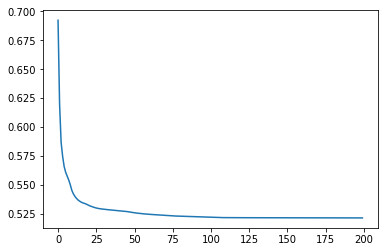

In [15]:
plt.plot(epoch_costs)

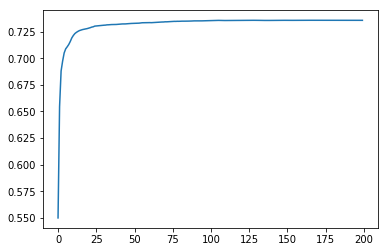

In [16]:
plt.plot(epoch_accuracy)